### Mini-projeto MLP (Multilayer Perceptron)
<li>Guilherme Morone (gma2)</li>
<li>Lucca Morosini (lmg2)</li>
<li>Mateus Elias (meap)</li>
<li>Williams Santiago (wssf) </li>

### Importando dependências e definindo funções úteis

In [1]:
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.neural_network import MLPClassifier
import numpy as np

In [2]:
# Definindo o DataFrame com os resultados das predições dos modelos de cada leva
def build_dataframe(results):
    df = pd.DataFrame(results)
    df['metric'] = (df.precision + df.recall + df.roc) / 3
    df = df.sort_values(by=['metric','precision', 'roc', 'recall'], ascending=False).reset_index(drop=True)
    return df

In [3]:
# Calculando o dicionário com os resultados das predições dos modelos por leva
def plot_model_stats(NCOLS, models, model_names, X_test, y_test, leva):
    fig, ax = plt.subplots(ncols=NCOLS, figsize=(20,4))
    fig.tight_layout()
    
    results = []

    for i in range(NCOLS):
        results += [plot_confusion_matrix(models[i], X_test, y_test, ax[i], model_names[i], leva)]
        ax[i].set_title(model_names[i])

    plt.show()
    return results

In [4]:
# Define o yhat, a matriz de confusão e os scores necessários para um modelo de uma determinada leva
def plot_confusion_matrix(model, X, y, ax, model_name, leva):
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)[:, 1]
    
    cm = confusion_matrix(y, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot(ax=ax)
    
    data = {
        'model_name': model_name,
        'model_shape': model.hidden_layer_sizes,
        'leva': leva,
        'precision': round(precision_score(y, y_pred), 4),
        'recall': round(recall_score(y, y_pred), 4),
        'roc': round(roc_auc_score(y, y_pred_prob), 4)
    }
    
    return data

### Lendo a base de dados e fazendo pré-processamento inicial

In [5]:
base = pd.read_csv("../dataset/observations.csv")

In [6]:
base.shape

(310, 14)

In [7]:
base.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att,Unnamed: 13
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,NaN
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal,NaN
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal,Prediction is done by using binary classificat...
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal,NaN
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal,NaN


In [8]:
# Dropando coluna não necessária 'Unnamed: 13'
base = base.drop(columns=['Unnamed: 13'])

In [9]:
# Renomeando colunas (no Kaggle encontramos os nomes das features)
base.columns = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'pelvic_slope', 'direct_tilt', 'thoracic_slope', 'cervical_tilt', 'sacrum_angle', 'scoliosis_slope', 'class']

In [10]:
# Ordinal encoding para a target feature
# 1 --> Abnormal
# 0 --> Normal
oe = OrdinalEncoder(dtype=np.intc, categories=[['Normal', 'Abnormal']])

# Aplicação do tranform na base e adicionando coluna de inteiros TARGET
base['TARGET'] = oe.fit_transform(base['class'].to_numpy().reshape(-1,1))

In [11]:
base.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,TARGET
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694,0.472979,21.321526,13.064511,11.933317,-14.053139,25.645981,0.677419
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027,0.285787,8.639423,3.399713,2.893265,12.225582,10.450558,0.468220
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179,0.003220,7.027000,7.037800,7.030600,-35.287375,7.007900,0.000000
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727,0.224367,13.054400,10.417800,9.541140,-24.289522,17.189075,0.000000
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934,0.475989,21.907150,12.938450,11.953835,-14.622856,24.931950,1.000000
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352,0.704846,28.954075,15.889525,14.371810,-3.497094,33.979600,1.000000
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082,0.998827,36.743900,19.324000,16.821080,6.972071,44.341200,1.000000


### Entendendo a relação dois a dois entre as features da base na determinância da classe alvo

In [12]:
pairs = []

# pairs tem todas as combinações das 12 features 2 a dois
for i in range(12):
    for j in range(12):
        if i != j:
            coli = base.columns[i]
            colj = base.columns[j]
            if ([coli, colj] not in pairs) and ([colj, coli] not in pairs):
                pairs.append([coli, colj])

Os scatter plots abaixo mostram algumas das distribuições das features duas a duas e como essa relação entre elas é determinante na definição do TARGET como <strong>Abnormal</strong> ou <strong>Normal</strong>.

Alguns pares de features como <strong><em>pelvic_radius</em></strong> e <strong><em>lumbar_lordosis_angle</em></strong>, bem como <strong><em>sacral_slope</em></strong> e <strong><em>degree_spondylolisthesis</em></strong> se distribuem de tal maneira que é visível uma separação entre regiões de casos 'Normais' e 'Anormais'.

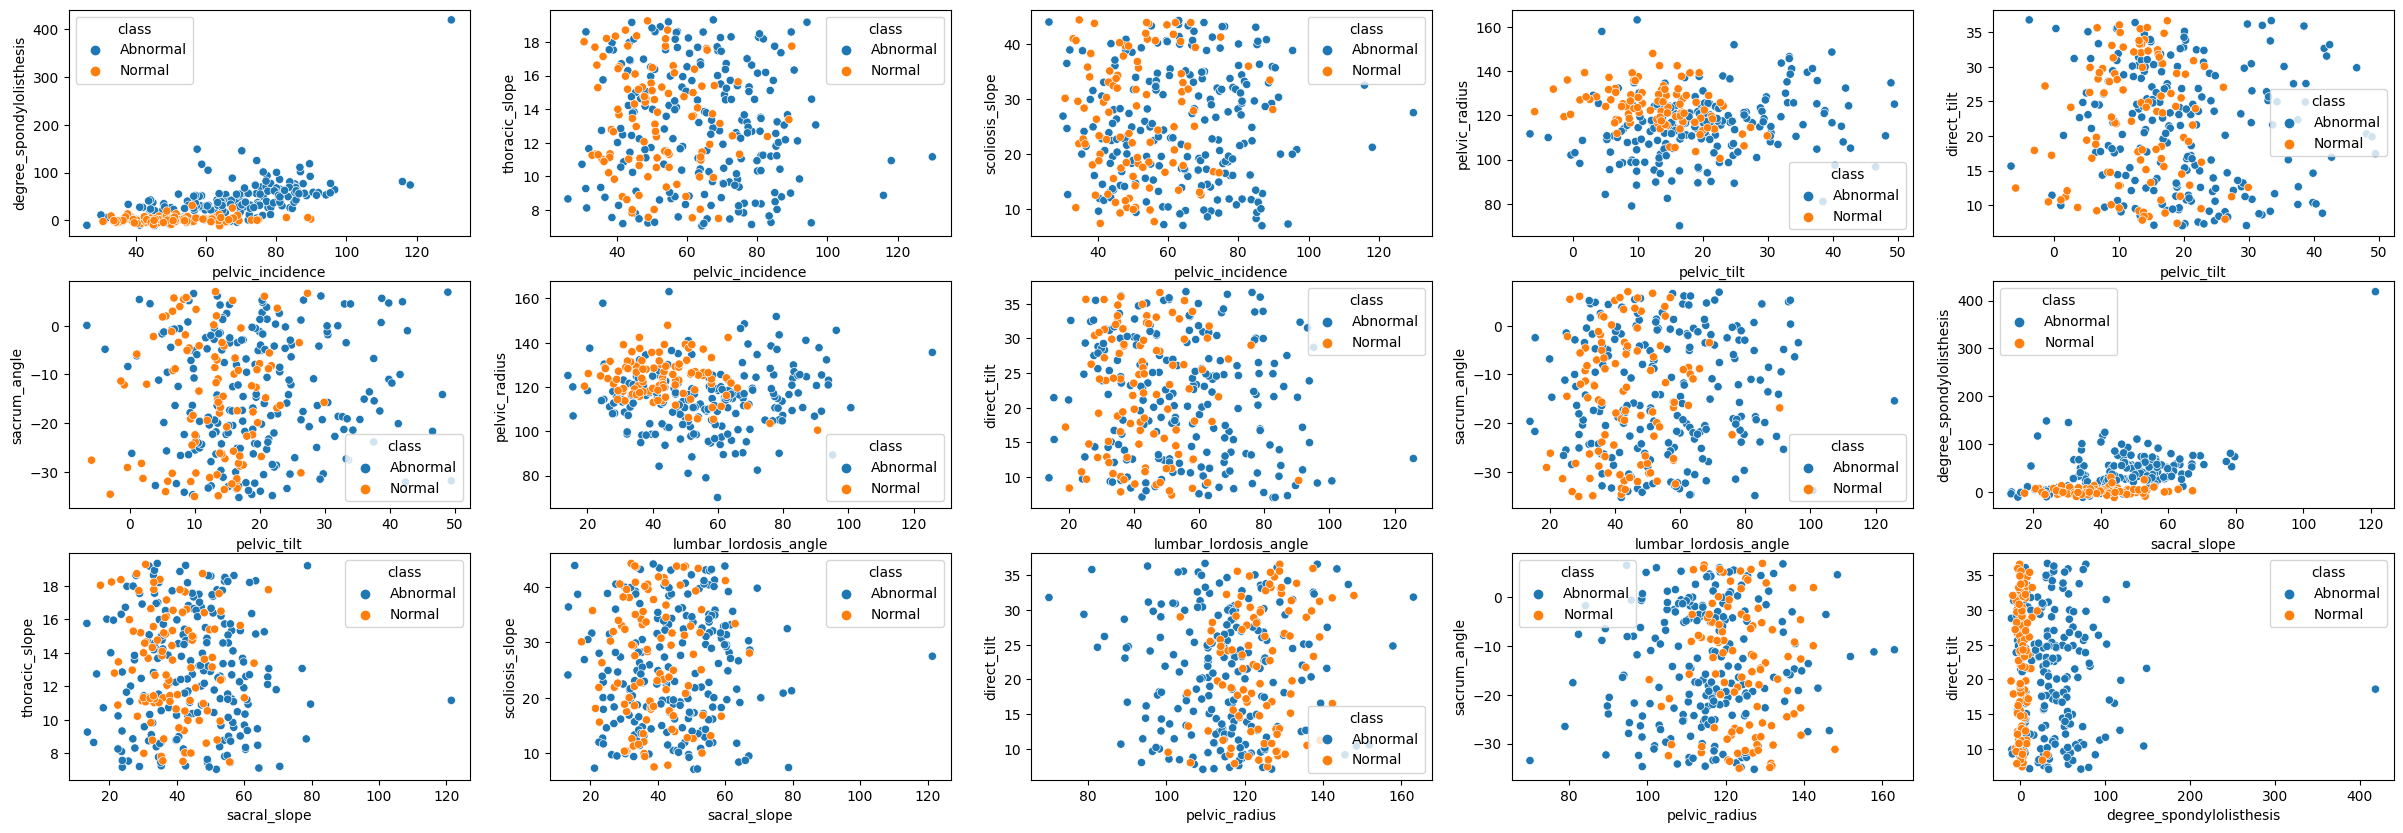

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(30,10))

i=0
j=0
for k in range(4, 49, 3):
    if j >= 5:
        j=0
        i += 1
    pair = pairs[k]
    data = base[[pair[0], pair[1], 'class']]
    sns.scatterplot(data=data, x=pair[0], y=pair[1], hue="class", ax=ax[i][j])
    j += 1

plt.show()

### Histograma com distribuições

Aqui percebemos que algumas features se distribuem na base de maneira próxima a uma distribuição normal, enquanto outras se aproximam mais de distribuições uniformes. A estimativa de densidade kernel <strong>(KDE)</strong> nos ajuda a chegar a tais conclusões.

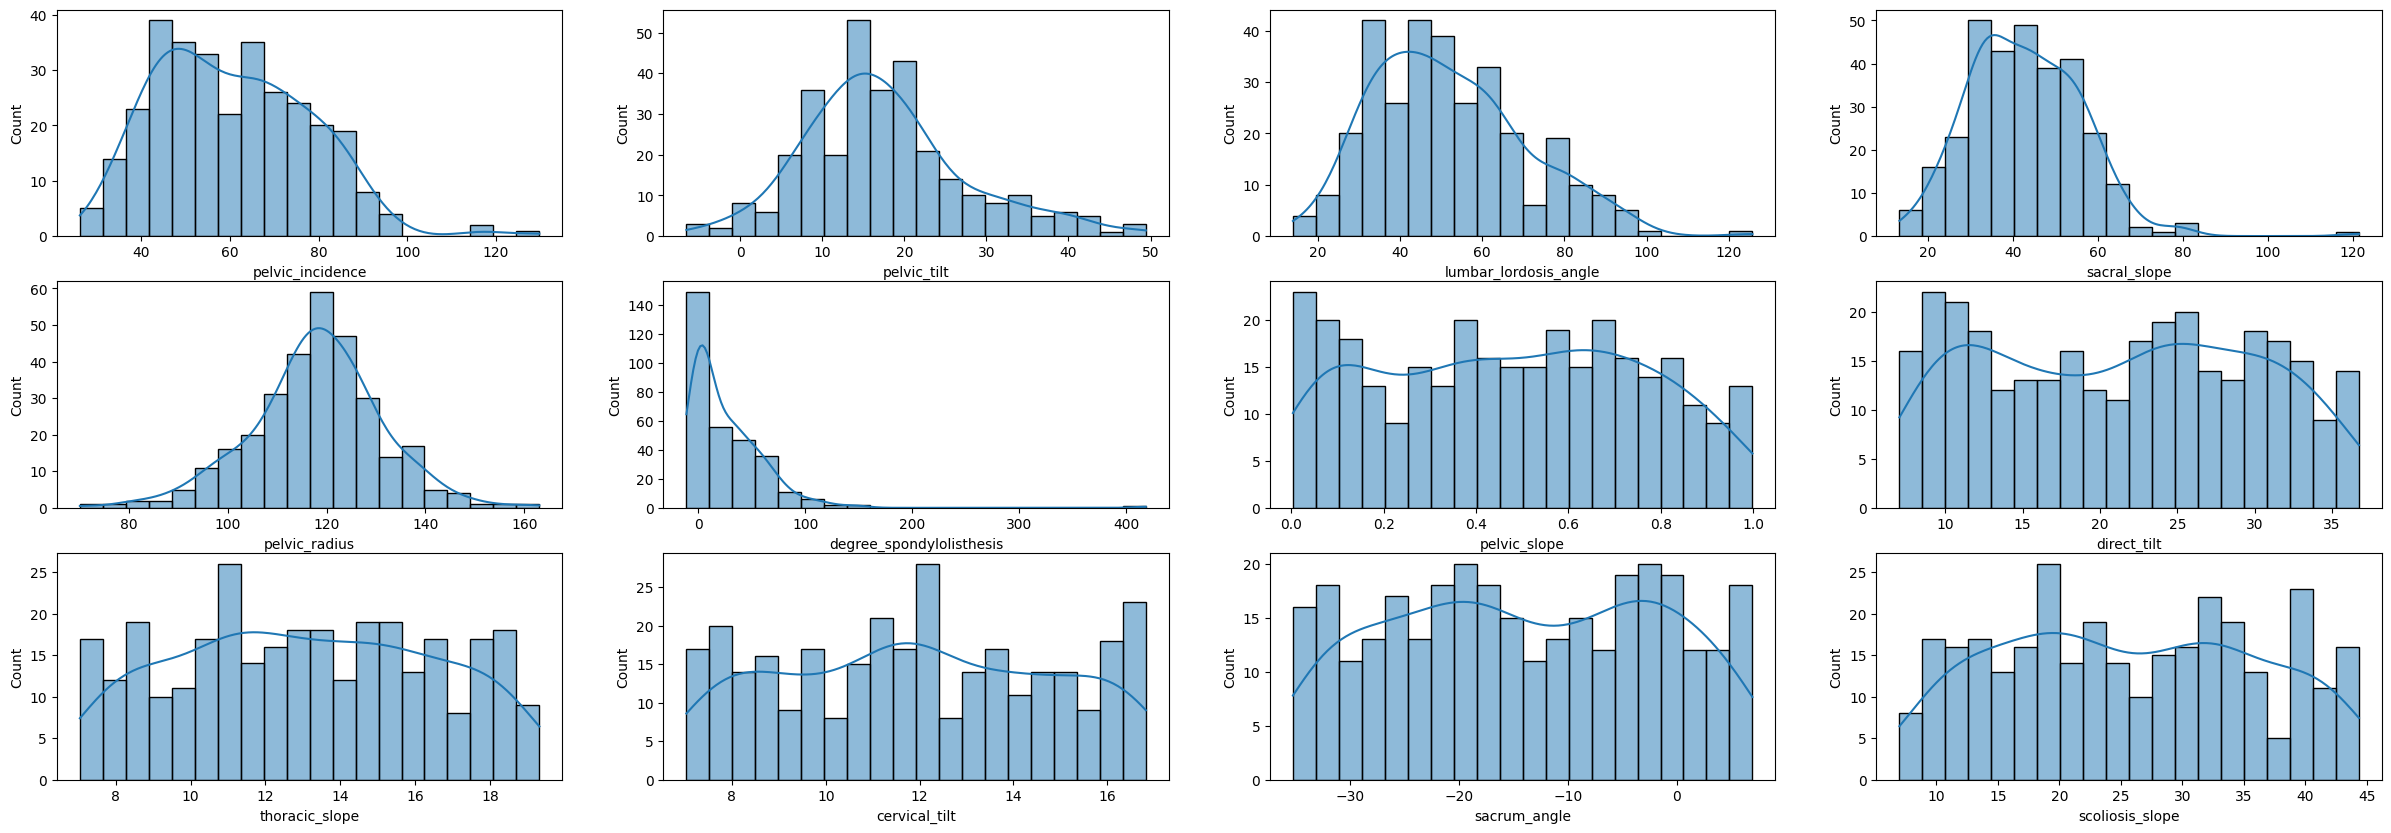

In [14]:
# Histograma das 12 features da base original pré-processada
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(30,10))

i = 0
j = 0
for k in range(12):
    if j >= 4:
        j = 0
        i += 1
    sns.histplot(data=base, x=base.columns[k], bins=20, kde=True, ax=ax[i][j])
    j += 1

### Separando a base em treino e teste.

In [15]:
base = base.drop(columns=['class'])

In [16]:
# Matriz de features X e vetor TARGET y
X_ = base.loc[:, base.columns != 'TARGET']
y_ = base.TARGET

# Separando a base pré-processada em bases treino e teste
# seguindo uma proporção de 25% para a de teste
X_train, X_test, y_train, y_test = train_test_split(
X_, y_, test_size=0.25, random_state=42)

In [17]:
# Inicializando scaler para realizar scaling nas
# matrizes de features de treino e teste
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.fit_transform(X_test))

In [18]:
X_train.shape

(232, 12)

In [19]:
X_test.shape

(78, 12)

### Treinando modelos diferentes

Para a avaliação dos modelos, iremos considerar como métrica a média aritmética entre o <strong>Recall, Precision e ROC scores.</strong> Assim, priorizamos os modelos que minimizam os falsos negativos (mais importantes na predição do diagnóstico) e falsos positivos, bem como aqueles que definem uma melhor curva ROC.

In [20]:
total_results = None

#### Primeira leva: comparando as funções de ativação em modelos com 1 hidden layer

Os modelos convergem mais rapidamente a depender da função de ativação utilizada. Isso é perceptível na verificação experimental do 'max_iter' para garantir convergência durante o treinamento.

In [21]:
model_id   = MLPClassifier(hidden_layer_sizes=(5,), activation="identity", random_state=42, max_iter=800).fit(X_train, y_train) 
model_log = MLPClassifier(hidden_layer_sizes=(5,), activation="logistic", random_state=42, max_iter=1100).fit(X_train, y_train)
model_relu = MLPClassifier(hidden_layer_sizes=(5,), activation="relu", random_state=42, max_iter=900).fit(X_train, y_train)
model_tanh = MLPClassifier(hidden_layer_sizes=(5,), activation="tanh", random_state=42, max_iter=900).fit(X_train, y_train)

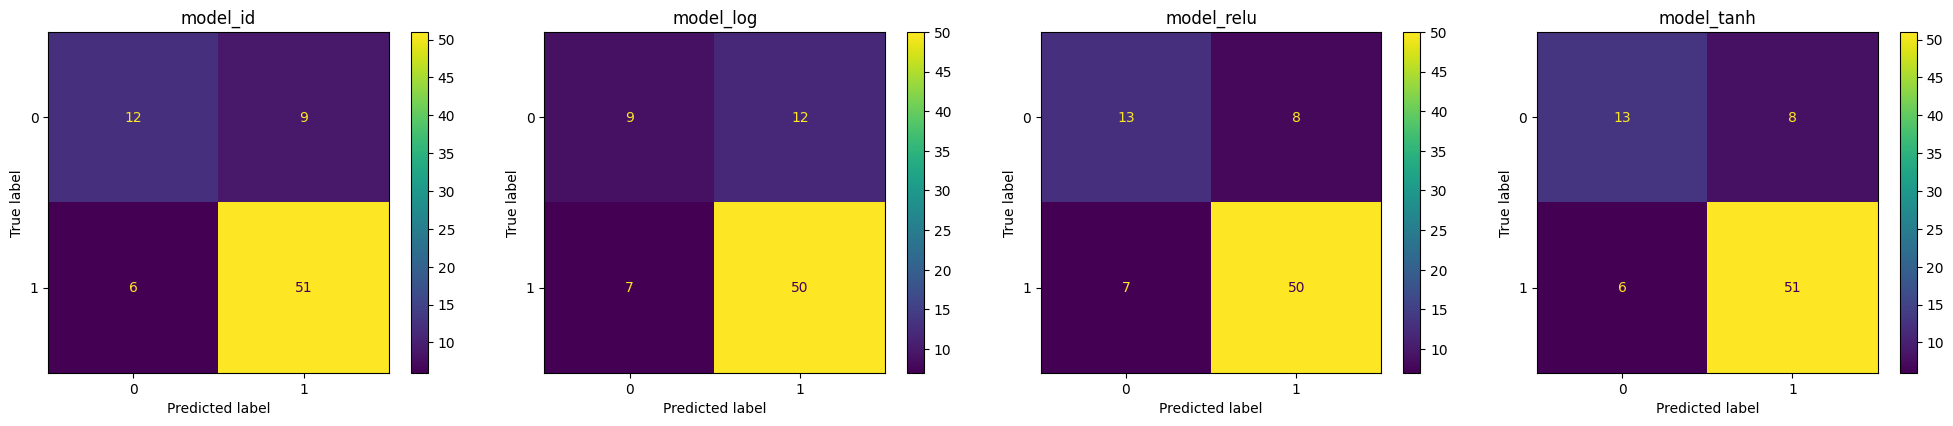

In [22]:
results_1 = plot_model_stats(4, [model_id, model_log, model_relu, model_tanh], ['model_id', 'model_log', 'model_relu', 'model_tanh'], X_test, y_test, 1)

O modelo cuja função de ativação é 'tanh' obtém a melhor métrica definida em comparação com os outros modelos.

In [23]:
results_1 = build_dataframe(results_1)
results_1

,model_name,model_shape,leva,precision,recall,roc,metric
0,model_tanh,"(5,)",1,0.8644,0.8947,0.8922,0.883767
1,model_id,"(5,)",1,0.8500,0.8947,0.8739,0.872867
2,model_relu,"(5,)",1,0.8621,0.8772,0.8571,0.865467
3,model_log,"(5,)",1,0.8065,0.8772,0.8388,0.840833


#### Segunda leva: comparando os solvers em modelos com 1 hidden layer e 'tanh' como função de ativação nos neurônios

Os modelos convergem mais rapidamente a depender do solver aplicado. Isso é perceptível na verificação experimental do 'max_iter' para garantir convergência durante o treinamento.

In [24]:
model_lbfgs   = MLPClassifier(hidden_layer_sizes=(5,), activation="tanh", random_state=42, solver='lbfgs', max_iter=2950).fit(X_train, y_train) 
model_sgd = MLPClassifier(hidden_layer_sizes=(5,), activation="tanh", random_state=42, solver='sgd', max_iter=350).fit(X_train, y_train)
model_adam = MLPClassifier(hidden_layer_sizes=(5,), activation="tanh", random_state=42, solver='adam', max_iter=900).fit(X_train, y_train)

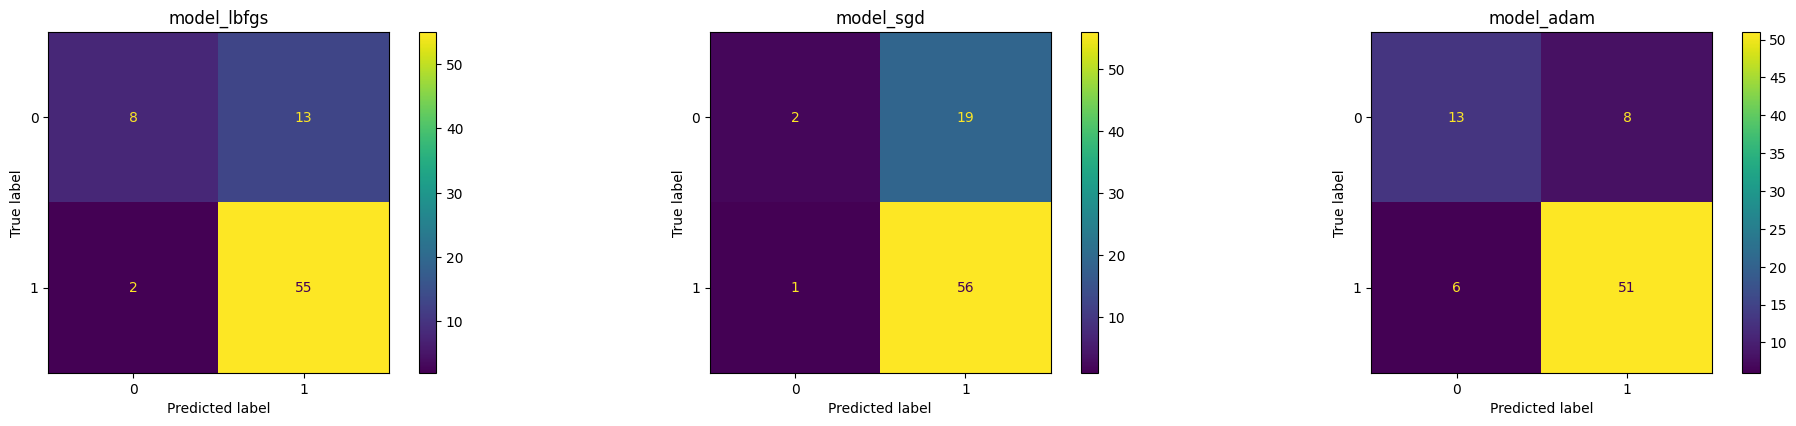

In [25]:
results_2 = plot_model_stats(3, [model_lbfgs, model_sgd, model_adam], ['model_lbfgs', 'model_sgd', 'model_adam'], X_test, y_test, 2)

O optimizer padrão 'adam' é aquele que tem a melhor performance, de acordo com nossa métrica, quando comparado aos outros solvers.

In [26]:
results_2 = build_dataframe(results_2)
results_2

,model_name,model_shape,leva,precision,recall,roc,metric
0,model_adam,"(5,)",2,0.8644,0.8947,0.8922,0.883767
1,model_lbfgs,"(5,)",2,0.8088,0.9649,0.7853,0.853000
2,model_sgd,"(5,)",2,0.7467,0.9825,0.6182,0.782467


#### Terceira leva: comparando quantidade de neurônios ativados com 'tanh' em modelos com 1 hidden layer configurados com o default 'adam' solver

Os modelos convergem mais rapidamente a depender da quantidade de neurônios na hidden layer. Isso é perceptível na verificação experimental do 'max_iter' para garantir convergência durante o treinamento.

In [27]:
model_1 = MLPClassifier(hidden_layer_sizes=(5,), activation="tanh", random_state=42, max_iter=900).fit(X_train, y_train)
model_2 = MLPClassifier(hidden_layer_sizes=(8,), activation="tanh", random_state=42, max_iter=1275).fit(X_train, y_train)
model_3 = MLPClassifier(hidden_layer_sizes=(16,), activation="tanh", random_state=42, max_iter=1600).fit(X_train, y_train)
model_4 = MLPClassifier(hidden_layer_sizes=(32,), activation="tanh", random_state=42, max_iter=1600).fit(X_train, y_train)

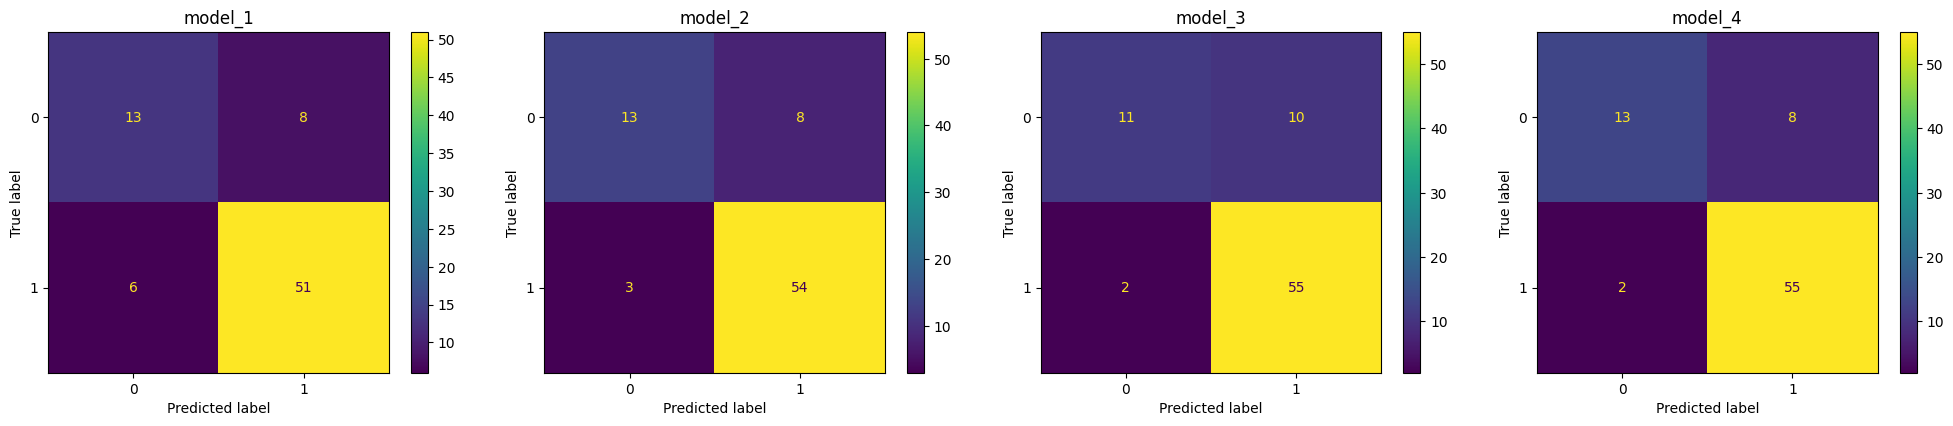

In [28]:
results_3 = plot_model_stats(4, [model_1, model_2, model_3, model_4], ['model_1', 'model_2', 'model_3', 'model_4'], X_test, y_test, 3)

O modelo de nome 'model_4' é aquele com melhor métrica calculada. Assim, considerando os resultados das levas anteriores, com uma única hidden layer, 32 neurônios melhor resolvem esse problema. Vale ressaltar que, para esse caso, os modelos não melhoram sempre à medida que cresce a quantidade de neurônios. 

In [29]:
results_3 = build_dataframe(results_3)
results_3

,model_name,model_shape,leva,precision,recall,roc,metric
0,model_4,"(32,)",3,0.8730,0.9649,0.9357,0.924533
1,model_2,"(8,)",3,0.8710,0.9474,0.9323,0.916900
2,model_3,"(16,)",3,0.8462,0.9649,0.9373,0.916133
3,model_1,"(5,)",3,0.8644,0.8947,0.8922,0.883767


#### Quarta leva: comparando quantidade de neurônios ativados com 'tanh' em modelos com 2 hidden layers configurados com o default 'adam' solver

Os modelos convergem mais rapidamente a depender da quantidade de neurônios nas duas hidden layers. Isso é perceptível na verificação experimental do 'max_iter' para garantir convergência durante o treinamento.

In [30]:
model_5 = MLPClassifier(hidden_layer_sizes=(5,5), activation="tanh", random_state=42, max_iter=1150).fit(X_train, y_train)
model_6 = MLPClassifier(hidden_layer_sizes=(8,4), activation="tanh", random_state=42, max_iter=1275).fit(X_train, y_train)
model_7 = MLPClassifier(hidden_layer_sizes=(16,8), activation="tanh", random_state=42, max_iter=1600).fit(X_train, y_train)
model_8 = MLPClassifier(hidden_layer_sizes=(32,16), activation="tanh", random_state=42, max_iter=1600).fit(X_train, y_train)

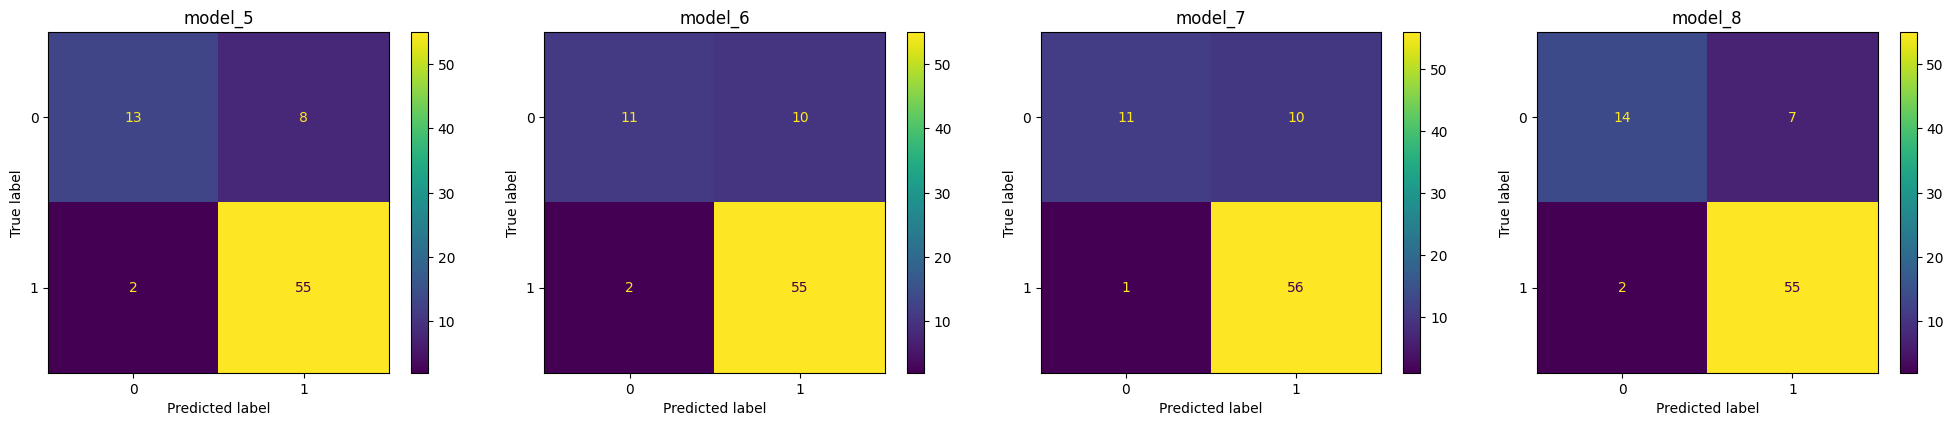

In [31]:
results_4 = plot_model_stats(4, [model_5, model_6, model_7, model_8], ['model_5', 'model_6', 'model_7', 'model_8'], X_test, y_test, 4)

O modelo de nome 'model_8' é aquele com melhor métrica calculada. Assim, considerando os resultados das levas anteriores, com duas hidden layers, 48 neurônios (32 na primeira e 16 na segunda camada) melhor resolvem esse problema. Vale ressaltar que, para esse caso, os modelos não melhoram sempre à medida que cresce a quantidade de neurônios. 

In [32]:
results_4 = build_dataframe(results_4)
results_4

,model_name,model_shape,leva,precision,recall,roc,metric
0,model_8,"(32, 16)",4,0.8871,0.9649,0.9373,0.929767
1,model_5,"(5, 5)",4,0.8730,0.9649,0.9390,0.925633
2,model_7,"(16, 8)",4,0.8485,0.9825,0.9398,0.923600
3,model_6,"(8, 4)",4,0.8462,0.9649,0.9315,0.914200


### Análise de correlação de Pearson para feature selection

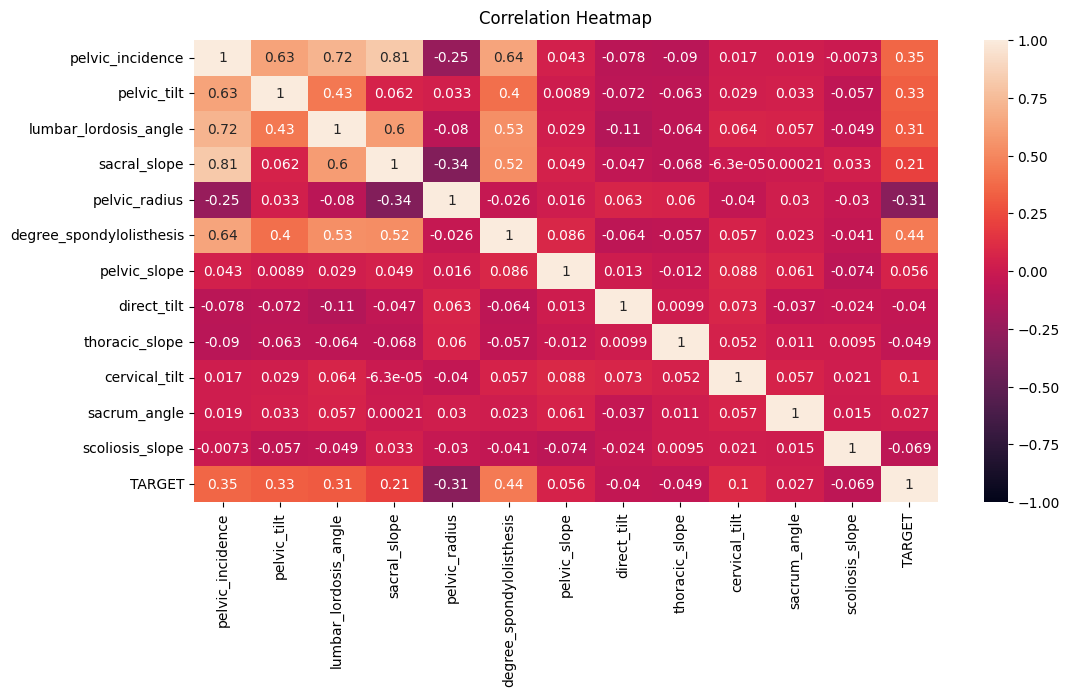

In [33]:
plt.figure(figsize=(12, 6))
hm = sns.heatmap(base.corr(numeric_only=True), annot=True, vmin=-1, vmax=1);
hm.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Esses coeficientes de correlação são os mais próximos de 0 para essas 6 features e são estatisticamente significativos, dado que seus p-values são maiores que a referência padrão 0.05. Assim, podemos interpretar o fato de que essas features não são tão determinantes para classificação dos nossos registros. 

In [34]:
target_corr = []
for col in base.columns:
    res = pearsonr(base[col], base.TARGET)
    if res.pvalue > 0.05:
        target_corr.append({'feature': col, 'statistic': res.statistic, 'p-value': res.pvalue})
target_corr = pd.DataFrame(target_corr)
target_corr

,feature,statistic,p-value
0,pelvic_slope,0.055865,0.326887
1,direct_tilt,-0.039591,0.487351
2,thoracic_slope,-0.049354,0.386500
3,cervical_tilt,0.100044,0.078618
4,sacrum_angle,0.026887,0.637238
5,scoliosis_slope,-0.069315,0.223620


Removendo as features selecionadas e definindo uma nova base que será treinada em novos modelos para avaliação da performance.

In [35]:
irrel_columns = target_corr.feature.to_numpy()

In [36]:
corr_base = base.loc[:, [col for col in base.columns if col not in irrel_columns]]
corr_base.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,TARGET
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1


#### Redefinindo matriz de features e vetor TARGET após a feature selection

In [37]:
X_corr_ = corr_base.loc[:, corr_base.columns != 'TARGET']
y_corr_ = corr_base.TARGET

X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(
X_corr_, y_corr_, test_size=0.25, random_state=42)

Matrizes de features de treino e teste agora com apenas 6 features das 12 originais após remoção.

In [38]:
X_train_corr.shape

(232, 6)

In [39]:
X_test_corr.shape

(78, 6)

In [40]:
# Realizando scaling nas bases de treino e teste
X_train_corr = pd.DataFrame(scaler.fit_transform(X_train_corr))
X_test_corr = pd.DataFrame(scaler.fit_transform(X_test_corr))

#### Quinta leva: comparando quantidade de neurônios ativados com 'tanh' em modelos com 1 hidden layers configurados com o default 'adam' solver após feature selection

Os modelos convergem mais rapidamente a depender da quantidade de neurônios na hidden layer. Isso é perceptível na verificação experimental do 'max_iter' para garantir convergência durante o treinamento.

In [41]:
corr_model_1 = MLPClassifier(hidden_layer_sizes=(5,), activation="tanh", random_state=42, max_iter=1600).fit(X_train_corr, y_train_corr)
corr_model_2 = MLPClassifier(hidden_layer_sizes=(8,), activation="tanh", random_state=42, max_iter=1500).fit(X_train_corr, y_train_corr)
corr_model_3 = MLPClassifier(hidden_layer_sizes=(16,), activation="tanh", random_state=42, max_iter=1400).fit(X_train_corr, y_train_corr)
corr_model_4 = MLPClassifier(hidden_layer_sizes=(32,), activation="tanh", random_state=42, max_iter=1450).fit(X_train_corr, y_train_corr)

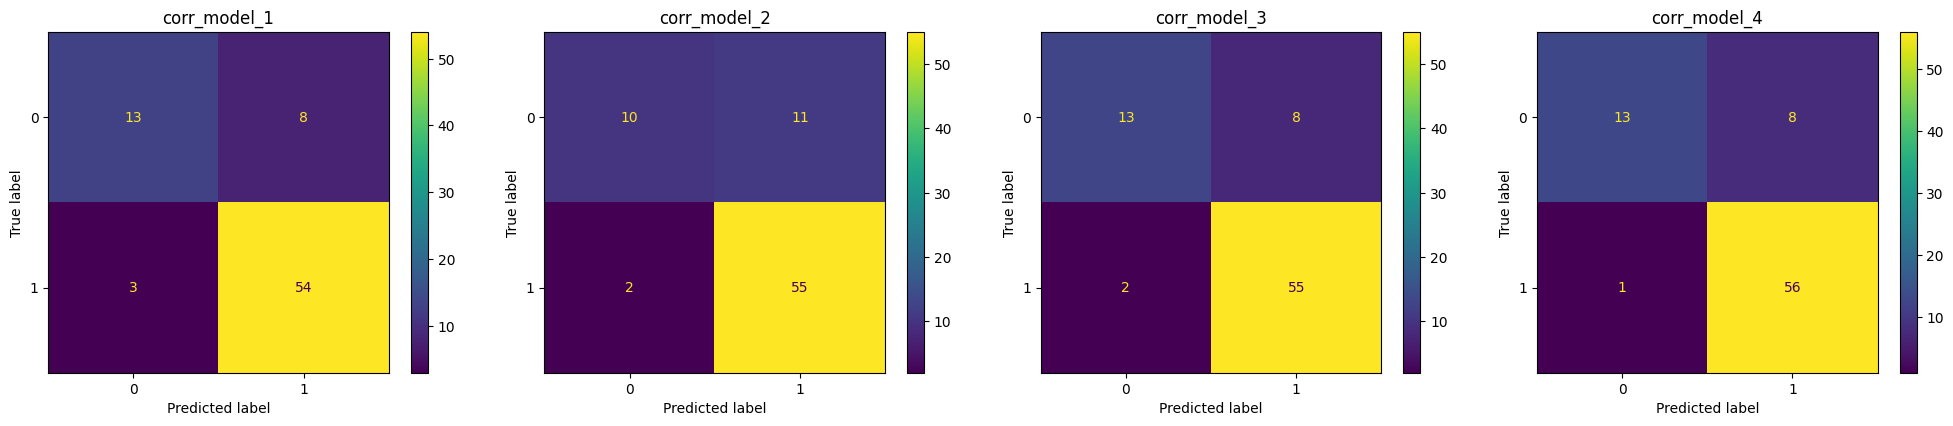

In [42]:
results_5 = plot_model_stats(4, [corr_model_1, corr_model_2, corr_model_3, corr_model_4], ['corr_model_1', 'corr_model_2', 'corr_model_3', 'corr_model_4'], X_test_corr, y_test_corr, 5)

O modelo de nome 'corr_model_4' é o que obtém melhor métrica dentre os demais. Analisando sua matriz de confusão, percebemos que ele é aquele com menor taxa de falsos negativos e positivos simultaneamente.

In [43]:
results_5 = build_dataframe(results_5)
results_5

,model_name,model_shape,leva,precision,recall,roc,metric
0,corr_model_4,"(32,)",5,0.8750,0.9825,0.9432,0.933567
1,corr_model_3,"(16,)",5,0.8730,0.9649,0.9424,0.926767
2,corr_model_1,"(5,)",5,0.8710,0.9474,0.9357,0.918033
3,corr_model_2,"(8,)",5,0.8333,0.9649,0.9365,0.911567


#### Sexta leva: comparando quantidade de neurônios ativados com 'tanh' em modelos com 2 hidden layers configurados com o default 'adam' solver após feature selection

Os modelos convergem mais rapidamente a depender da quantidade de neurônios nas duas hidden layers. Isso é perceptível na verificação experimental do 'max_iter' para garantir convergência durante o treinamento.

In [44]:
corr_model_5 = MLPClassifier(hidden_layer_sizes=(5,5), activation="tanh", random_state=42, max_iter=1300).fit(X_train_corr, y_train_corr)
corr_model_6 = MLPClassifier(hidden_layer_sizes=(8,4), activation="tanh", random_state=42, max_iter=1100).fit(X_train_corr, y_train_corr)
corr_model_7 = MLPClassifier(hidden_layer_sizes=(16,8), activation="tanh", random_state=42, max_iter=800).fit(X_train_corr, y_train_corr)
corr_model_8 = MLPClassifier(hidden_layer_sizes=(32,16), activation="tanh", random_state=42, max_iter=550).fit(X_train_corr, y_train_corr)

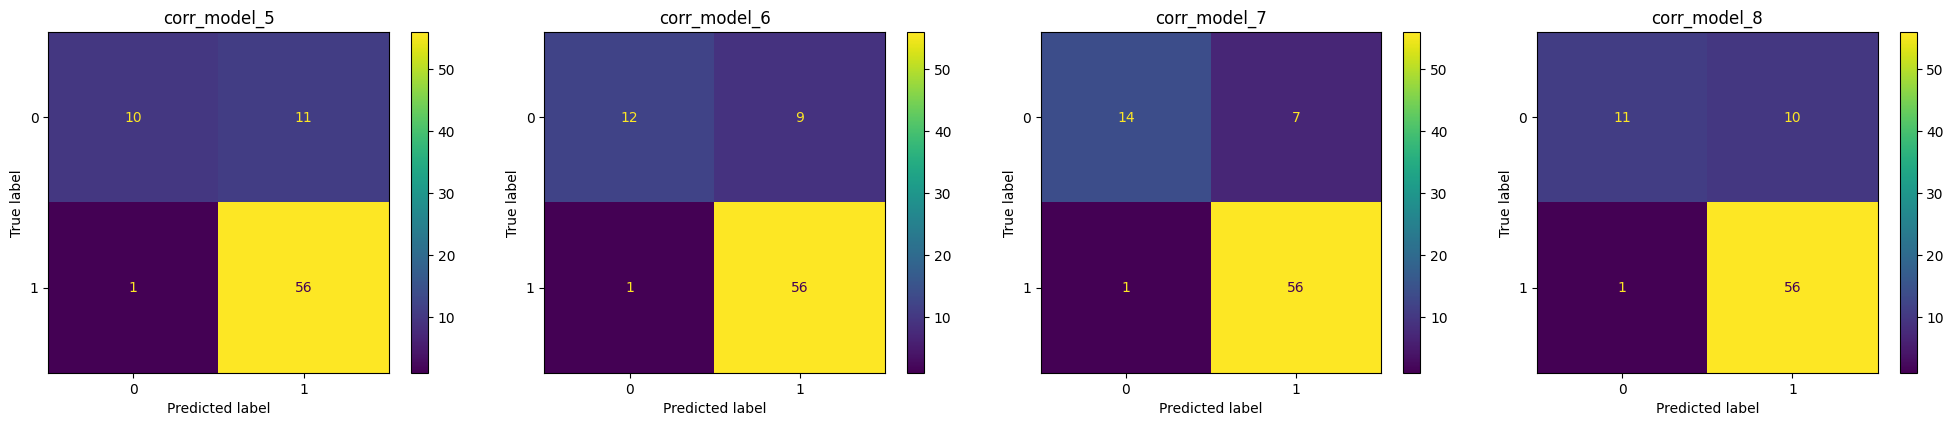

In [45]:
results_6 = plot_model_stats(4, [corr_model_5, corr_model_6, corr_model_7, corr_model_8], ['corr_model_5', 'corr_model_6', 'corr_model_7', 'corr_model_8'], X_test_corr, y_test_corr, 6)

Aqui na sexta leva, conseguimos encontrar o melhor modelo entre os demais treinados anteriormente. O 'corr_model_7' é aquele com melhor recall, precision e com uma das melhores ROC curves (atrás apenas em cerca de 0.08% do maior roc score calculado).

In [46]:
results_6 = build_dataframe(results_6)
results_6

,model_name,model_shape,leva,precision,recall,roc,metric
0,corr_model_7,"(16, 8)",6,0.8889,0.9825,0.9424,0.937933
1,corr_model_6,"(8, 4)",6,0.8615,0.9825,0.9432,0.929067
2,corr_model_8,"(32, 16)",6,0.8485,0.9825,0.9424,0.924467
3,corr_model_5,"(5, 5)",6,0.8358,0.9825,0.9398,0.919367


### Conclusão

Em cada uma das 'levas' de treinamento de modelos diferentes, avaliamos alguns hiperparâmetros para seguir adiante em busca de melhores modelos. Após alguns treinamentos, foi possível concluir que modelos com função de ativação 'tanh' e solver 'adam' melhor se encaixam para classificar essa base original. Ademais, após a análise de correlação de Pearson, conseguimos melhorar nossa performance e definir modelos com menos neurônios (sejam divididos em uma ou duas hidden layer) que performam melhor que outros com duas camadas e mais neurônios.

Finalmente, o modelo que sugerimos como o que melhor se encaixa têm as seguintes propriedades:
<li><em>tanh</em> como função de ativação das unidades de processamento</li>
<li>default <em>adam</em> solver</li>
<li>precision score: 88.89%</li>
<li>recall score: 98.25%</li>
<li>roc score: 94.24%</li>
<li>duas hidden layers: a primeira com 16 neurônios e a segunda com 8</li>

Abaixo estão os melhores modelos em cada leva de treinamento de acordo com nossa métrica.

In [47]:
total_results = pd.concat([results_1, results_2, results_3, results_4, results_5, results_6], axis=0)\
                  .reset_index(drop=True)\
                  .sort_values(by='leva', ascending=True)
greatests_per_leva = total_results.loc[total_results.groupby('leva')['metric'].idxmax()]\
                              .reset_index(drop=True)\
                              .sort_values(by='metric', ascending=False)
greatests_per_leva

,model_name,model_shape,leva,precision,recall,roc,metric
5,corr_model_7,"(16, 8)",6,0.8889,0.9825,0.9424,0.937933
4,corr_model_4,"(32,)",5,0.8750,0.9825,0.9432,0.933567
3,model_8,"(32, 16)",4,0.8871,0.9649,0.9373,0.929767
2,model_4,"(32,)",3,0.8730,0.9649,0.9357,0.924533
0,model_tanh,"(5,)",1,0.8644,0.8947,0.8922,0.883767
1,model_adam,"(5,)",2,0.8644,0.8947,0.8922,0.883767


In [48]:
greatests_plot = pd.melt(greatests_per_leva, id_vars=['model_name', 'model_shape'], value_vars=['precision', 'recall', 'roc', 'metric'])\
                   .sort_values(by='value', ascending=False)\
                   .reset_index(drop=True)

In [49]:
losses_corr_4 = corr_model_4.loss_curve_
losses_corr_7 = corr_model_7.loss_curve_
losses_8 = model_8.loss_curve_
losses_4 = model_4.loss_curve_
losses_tanh = model_tanh.loss_curve_
losses_adam = model_adam.loss_curve_

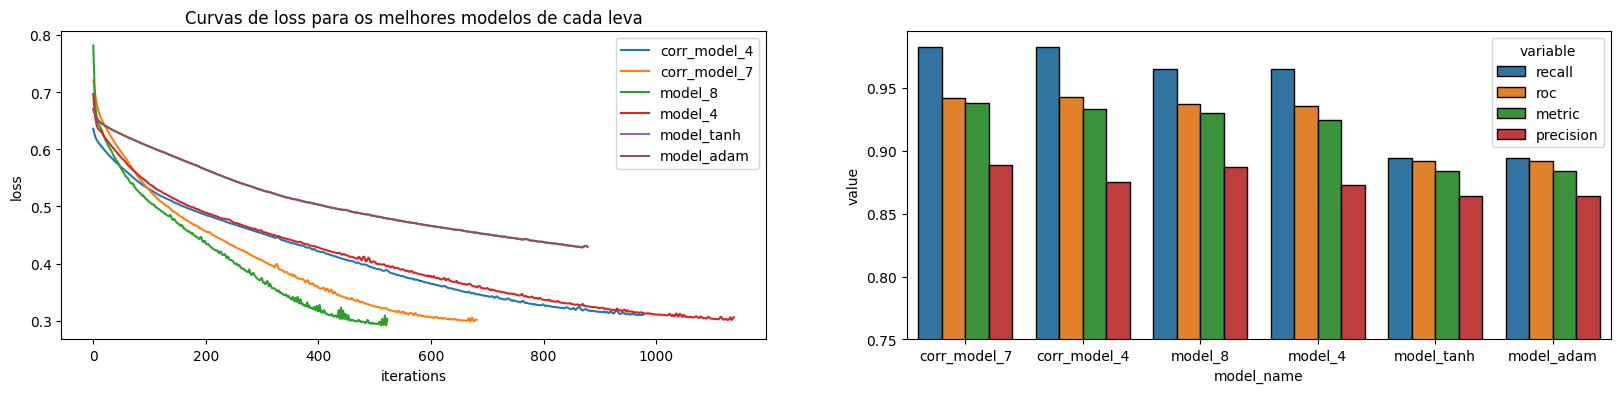

In [50]:
fig, ax = plt.subplots(ncols=2, figsize=(20,4))

ax[0].plot(losses_corr_4, label='corr_model_4')
ax[0].plot(losses_corr_7, label='corr_model_7')
ax[0].plot(losses_8, label='model_8')
ax[0].plot(losses_4, label='model_4')
ax[0].plot(losses_tanh, label='model_tanh')
ax[0].plot(losses_adam, label='model_adam')
ax[0].legend()
ax[0].set_ylabel('loss')
ax[0].set_xlabel('iterations')
ax[0].set_title('Curvas de loss para os melhores modelos de cada leva')

sns.barplot(data=greatests_plot, x="model_name", y="value", edgecolor='black', hue='variable', ax=ax[1])
ax[1].set_ylim(0.75, 0.995)

plt.show()